
# Experiment 4: Sensitivity Analysis ($\chi$ Landscape)

**核心问题**：心理敏感度 $\chi$ 是由阈值 $(\phi, \theta)$ 决定的。不同的阈值组合会导致怎样不同的敏感度？这对临界点 $r_c$ 有什么影响？

**实验设计**：
1. **Heatmap**: 在 $(\phi, \theta)$ 参数空间扫描 $\chi$ 的值。
2. **Critical Threshold**: 分析 $\chi$ 如何改变 $r_c$ 的位置。
3. **Bifurcation Impact**: (新增) 展示高/低敏感度下的分岔图差异。


In [1]:

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

ROOT_DIR = Path('..').resolve()
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

from src import theory
from src.sde_solver import SDEConfig, run_sde_simulation

sns.set_theme(style='whitegrid', palette='deep')

# Common Params
k_avg = 50
n_m, n_w = 10, 5
seed = 0


## 1. Sensitivity Heatmap ($\chi$ in Parameter Space)

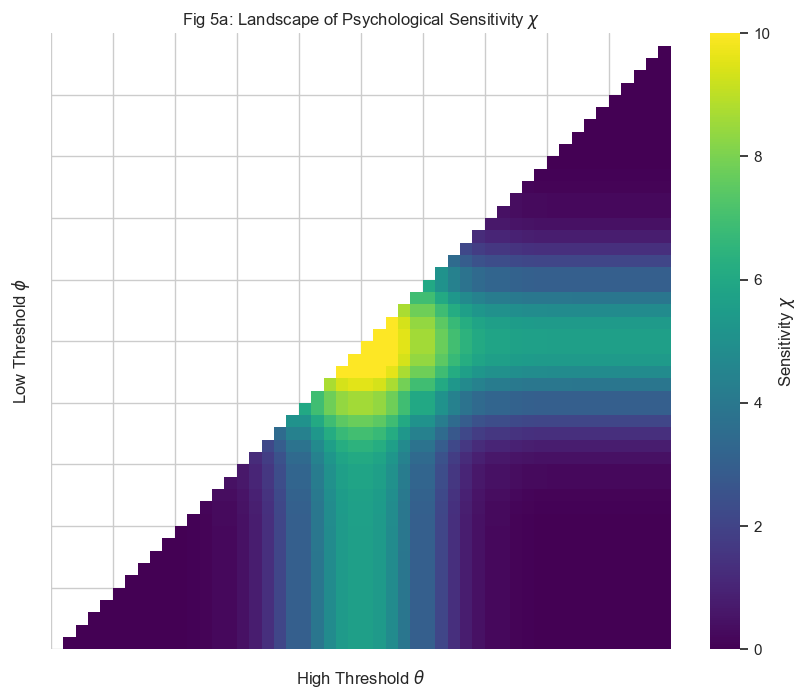

In [6]:

# 网格扫描
phi_range = np.linspace(0.1, 0.9, 50)
theta_range = np.linspace(0.1, 0.9, 50)
chi_map = np.zeros((len(phi_range), len(theta_range)))

for i, phi in enumerate(phi_range):
    for j, theta in enumerate(theta_range):
        if phi >= theta:  # 无效区域 (phi必须小于theta，或者至少不重叠)
            chi_map[i, j] = np.nan
        else:
            chi_map[i, j] = theory.calculate_chi(phi, theta, k_avg)

plt.figure(figsize=(10, 8))
sns.heatmap(
    chi_map,
    xticklabels=np.round(theta_range, 2),
    yticklabels=np.round(phi_range, 2),
    cmap='viridis',
    cbar_kws={'label': 'Sensitivity $\chi$'},
    vmin=0,
    vmax=10,
)
plt.xlabel(r'High Threshold $\theta$')
plt.ylabel('Low Threshold $\phi$')
plt.title('Fig 5a: Landscape of Psychological Sensitivity $\chi$')
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, 50, 5))
plt.yticks(np.arange(0, 50, 5))
plt.show()



**解读**：
- **对角线附近 ($\theta \approx \phi$)**：颜色最亮（$\chi$ 最大）。说明当阈值窗口极窄时，人群极度敏感。
- **远离对角线**：颜色变暗。说明窗口越宽，人群越迟钝。
- **结论**：敏感度主要由**窗口宽度** $(\theta - \phi)$ 决定。


## 2. Impact on Critical Threshold $r_c$

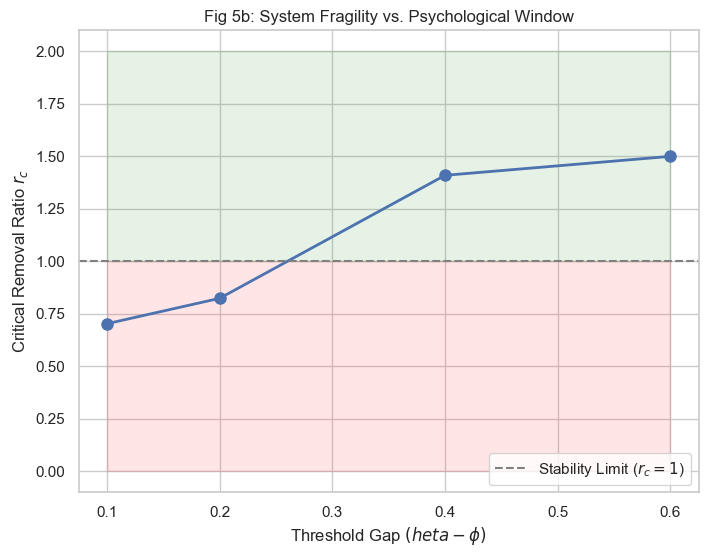

In [3]:

# 选取几组典型的 gap = theta - phi
gaps = [0.1, 0.2, 0.4, 0.6]
# 固定中心为 0.5 (对称假设)
center = 0.5

chi_list = []
rc_list = []

for gap in gaps:
    phi = center - gap / 2
    theta = center + gap / 2
    chi = theory.calculate_chi(phi, theta, k_avg)
    rc = theory.calculate_rc(n_m, n_w, chi)
    chi_list.append(chi)
    rc_list.append(rc)

plt.figure(figsize=(8, 6))
plt.plot(gaps, rc_list, 'o-', linewidth=2, markersize=8)
plt.axhline(1.0, color='gray', linestyle='--', label='Stability Limit ($r_c=1$)')
plt.xlabel('Threshold Gap $(\theta - \phi)$')
plt.ylabel('Critical Removal Ratio $r_c$')
plt.title('Fig 5b: System Fragility vs. Psychological Window')
plt.grid(True)
plt.legend()
plt.fill_between(gaps, 1.0, 2.0, color='green', alpha=0.1, label='Always Stable')
plt.fill_between(gaps, 0.0, 1.0, color='red', alpha=0.1, label='Can Polarize')
plt.show()



**解读**：
- **Gap 越小** $\to$ $\chi$ 越大 $\to$ $r_c$ 越小（甚至接近0）。这解释了为什么在 Fig 1 中 $\chi=4.19$ 时相变点那么早。
- **反之**：对于宽容度高的人群（Gap 大），$r_c > 1$，说明怎么折腾都不会极化。



## 3. Bifurcation under Different Sensitivity
展示不同 $\chi$ 下的分岔行为差异（回应 Fig 1 纵轴标签的问题）。


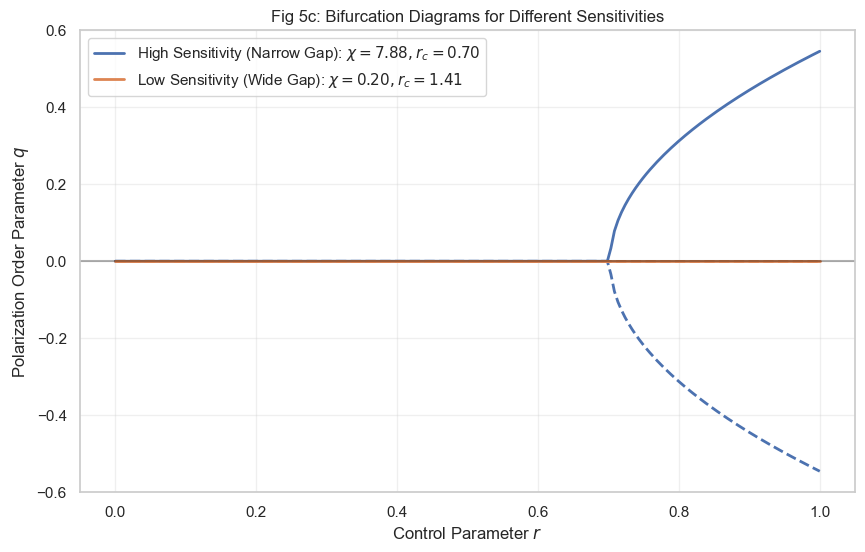

In [4]:

cases = [
    {'label': 'High Sensitivity (Narrow Gap)', 'phi': 0.45, 'theta': 0.55},
    {'label': 'Low Sensitivity (Wide Gap)', 'phi': 0.3, 'theta': 0.7},
]

r_scan = np.linspace(0, 1.0, 200)
plt.figure(figsize=(10, 6))

for case in cases:
    chi = theory.calculate_chi(case['phi'], case['theta'], k_avg)
    rc = theory.calculate_rc(n_m, n_w, chi)
    alpha_arr, u = theory.get_gl_params(r_scan, rc)
    q_upper = [np.sqrt(abs(a) / u) if a < 0 else 0 for a in alpha_arr]
    q_lower = [-q for q in q_upper]
    p = plt.plot(r_scan, q_upper, linewidth=2, label=f"{case['label']}: $\chi={chi:.2f}, r_c={rc:.2f}$")
    plt.plot(r_scan, q_lower, '--', color=p[0].get_color(), linewidth=2)

plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Control Parameter $r$')
plt.ylabel('Polarization Order Parameter $q$')
plt.title('Fig 5c: Bifurcation Diagrams for Different Sensitivities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## 4. SDE 分岔验证（对称分支，不取绝对值）
为每个敏感度在多个 r 上跑 SDE，直接绘制轨迹终点散点，展示上下分支对称性。


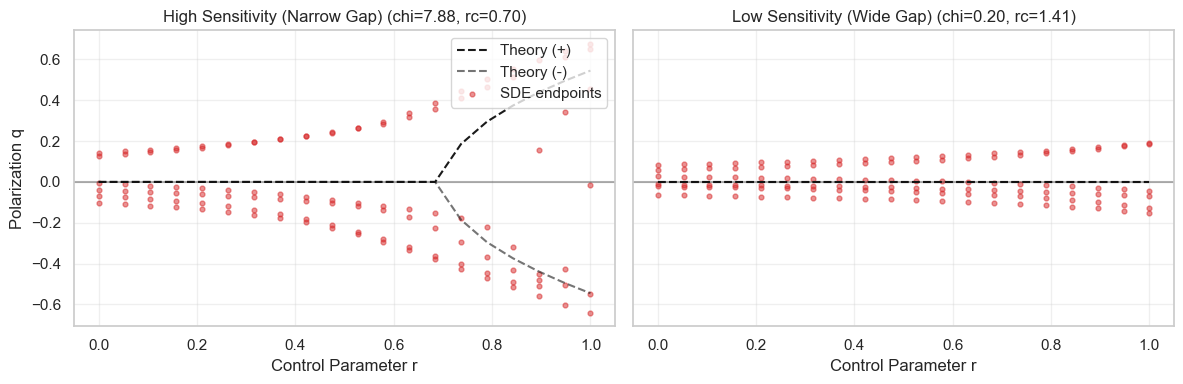

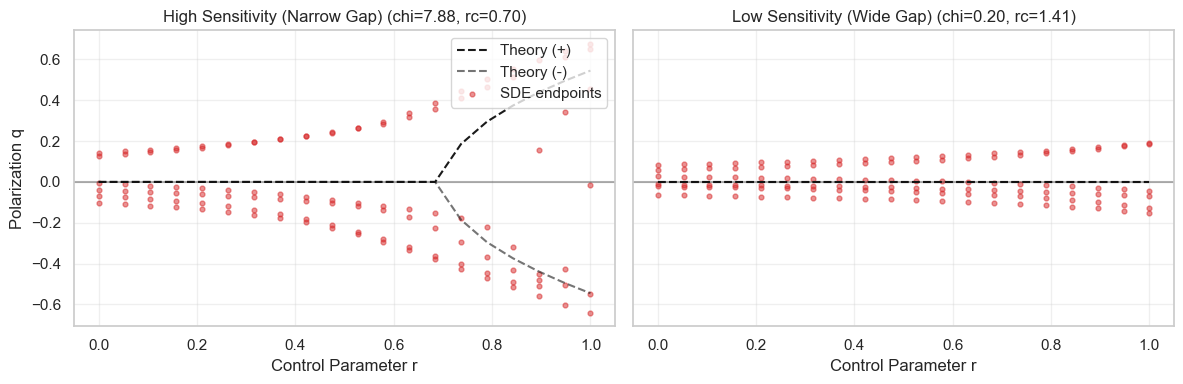

In [5]:

r_scan_sde = np.linspace(0, 1.0, 20)
n_traj = 6
steps = 8000
dt = 1e-2
sigma = 0.12

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, case in zip(axes, cases):
    chi = theory.calculate_chi(case['phi'], case['theta'], k_avg)
    rc = theory.calculate_rc(n_m, n_w, chi)
    alpha_arr, u = theory.get_gl_params(r_scan_sde, rc)
    q_branch = [np.sqrt(abs(a) / u) if a < 0 else 0 for a in alpha_arr]
    ax.plot(r_scan_sde, q_branch, 'k--', label='Theory (+)')
    ax.plot(r_scan_sde, -np.array(q_branch), 'k--', alpha=0.6, label='Theory (-)')

    scatter_r = []
    scatter_q = []
    for r in r_scan_sde:
        alpha, u = theory.get_gl_params(r=r, rc=rc)
        cfg = SDEConfig(alpha=float(alpha), u=u, sigma=sigma, dt=dt, steps=steps, n_trajectories=n_traj, seed=seed)
        _, traj = run_sde_simulation(cfg, q0=0.0, record_interval=200)
        scatter_r.append(np.full(n_traj, r))
        scatter_q.append(traj[-1])

    scatter_r = np.concatenate(scatter_r)
    scatter_q = np.concatenate(scatter_q)
    ax.scatter(scatter_r, scatter_q, s=12, alpha=0.5, color='tab:red', label='SDE endpoints')
    ax.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel('Control Parameter r')
    ax.set_title(f"{case['label']} (chi={chi:.2f}, rc={rc:.2f})")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Polarization q')
axes[0].legend(loc='upper right')
fig.tight_layout()
fig.savefig(ROOT_DIR / 'outputs' / 'sde_bifurcation_sensitivity.png', dpi=200)
fig
